# Regresión Logística para clasificación - Ejemplo Hipoteca
---

## Librerias

In [55]:
library(ggplot2)
library(readxl)
library(GGally) #para matriz de graficos
library(ResourceSelection)
library(DescTools)
library(caret) #para matriz de confusion 
library(ROCR)
library(gridExtra)
library(car)
library(vcd)

In [2]:
# Lineas para limpieza
rm(list=ls())

In [3]:
setwd("/Users/ppando/Materias/cs-datos/especializacion/aprendizaje-automatico/bd")

## Lectura de datos

In [5]:
datos <- read_excel("hipoteca25b.xlsx")
str(datos)

tibble [2,380 × 9] (S3: tbl_df/tbl/data.frame)
 $ id       : num [1:2380] 1 2 3 4 5 6 7 8 9 10 ...
 $ gasto    : num [1:2380] 0.221 0.265 0.372 0.32 0.36 ...
 $ rat      : num [1:2380] 0.8 0.922 0.92 0.86 0.6 ...
 $ rat.desem: num [1:2380] 3.9 3.2 3.2 4.3 3.2 ...
 $ malhist  : chr [1:2380] "no" "no" "no" "no" ...
 $ auton    : chr [1:2380] "no" "no" "no" "no" ...
 $ soltero  : chr [1:2380] "no" "yes" "no" "no" ...
 $ denegado : num [1:2380] 0 0 0 0 0 0 0 0 1 0 ...
 $ malhist3 : num [1:2380] 2 2 2 2 2 2 2 2 2 1 ...


In [6]:
# Se elimina id
datos <- datos[, -1]

## Declarar bien las variables

In [7]:
# Se transforma las variables cualitativas a factor
datos$denegado <- as.factor(datos$denegado)
datos$soltero <- as.factor(datos$soltero)
datos$auton <- as.factor(datos$auton)
datos$malhist <- as.factor(datos$malhist)
datos$malhist3 <- as.factor(datos$malhist3)

In [8]:
# Se muestra el summary
summary(datos)

     gasto             rat              rat.desem     malhist    auton     
 Min.   :0.0000   Min.   :0.000e+00   Min.   :0.000   no :2205   no :2103  
 1st Qu.:0.2800   1st Qu.:1.000e+00   1st Qu.:3.100   yes: 175   yes: 277  
 Median :0.3300   Median :1.000e+00   Median :3.200                        
 Mean   :0.3308   Mean   :8.600e+11   Mean   :3.013                        
 3rd Qu.:0.3700   3rd Qu.:1.000e+00   3rd Qu.:3.600                        
 Max.   :3.0000   Max.   :1.908e+14   Max.   :8.900                        
 soltero    denegado malhist3
 no :1444   0:2095   1: 309  
 yes: 936   1: 285   2:1896  
                     3: 175  
                             
                             
                             

## Estudio NA

In [9]:
# Se valida que no haya datos faltantes
sum(is.na(datos))

[1] 0

## Análisis de datos: ver valores atípicos, se eligen variables de interés

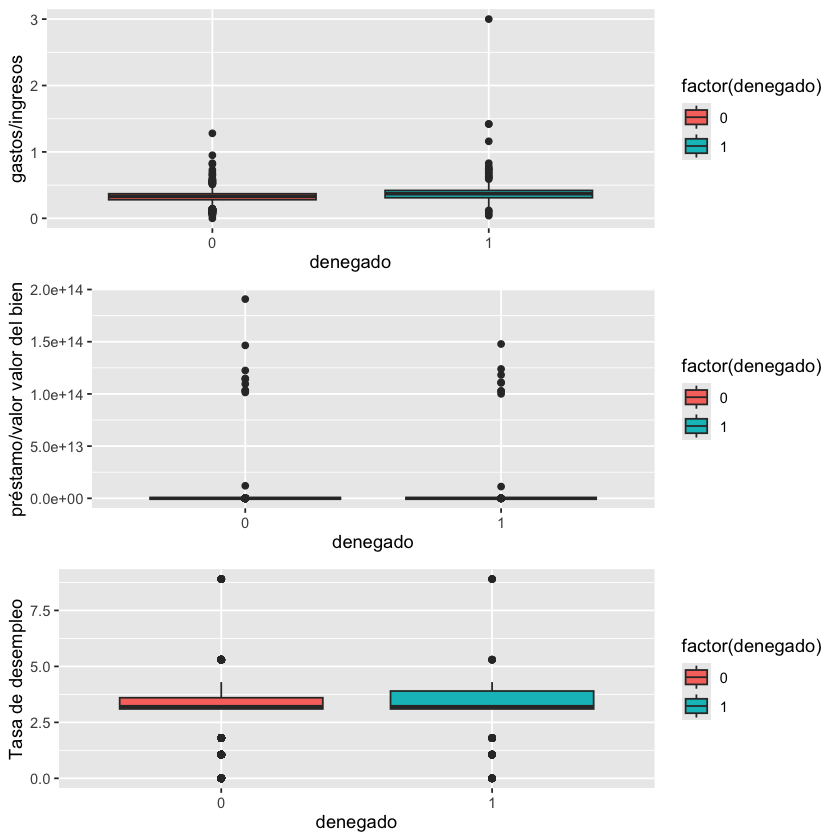

In [10]:
# Se analizan las variables disponibles para incluirlas de modo adecuado
# Análisis básico de cada VARIABLE NUMERICA respecto a denegado (la hipoteca)
bp1 <- ggplot(data = datos, aes(y = gasto), colour = factor(denegado)) +
  geom_boxplot(aes(x = denegado, fill = factor(denegado))) +
  xlab("denegado") + ylab("gastos/ingresos")

bp2 <-ggplot(data = datos, aes(y = rat), colour = factor(denegado)) +
  geom_boxplot(aes(x = denegado, fill = factor(denegado))) +
  xlab("denegado") + ylab("préstamo/valor valor del bien") 
  
bp3 <-ggplot(data = datos, aes(y = rat.desem), colour = factor(denegado)) +
  geom_boxplot(aes(x = denegado, fill = factor(denegado))) +
  xlab("denegado") + ylab("Tasa de desempleo")
  
grid.arrange(bp1, bp2, bp3)

In [11]:
# Se miran las escalas y se detectan datos muy atípicos en el préstamo solicitado respecto al valor del bien 
which(datos$rat >= 2) # son 26 casos
# Se eliminan los 26 casos
datos2 <- datos[datos$rat <1.5,]

[1]   43  114  231  285  299  369  500  505  784 1030 1158 1163 1170 1179 1217
[16] 1283 1325 1328 1831 1835 1928 1929 2231 2336

In [12]:
summary(datos2)

     gasto             rat           rat.desem     malhist    auton     
 Min.   :0.0000   Min.   :0.0200   Min.   :0.000   no :2182   no :2085  
 1st Qu.:0.2800   1st Qu.:0.6513   1st Qu.:3.100   yes: 172   yes: 269  
 Median :0.3300   Median :0.7778   Median :3.200                        
 Mean   :0.3297   Mean   :0.7324   Mean   :3.014                        
 3rd Qu.:0.3700   3rd Qu.:0.8639   3rd Qu.:3.600                        
 Max.   :3.0000   Max.   :1.2000   Max.   :8.900                        
 soltero    denegado malhist3
 no :1432   0:2082   1: 305  
 yes: 922   1: 272   2:1877  
                     3: 172  
                             
                             
                             

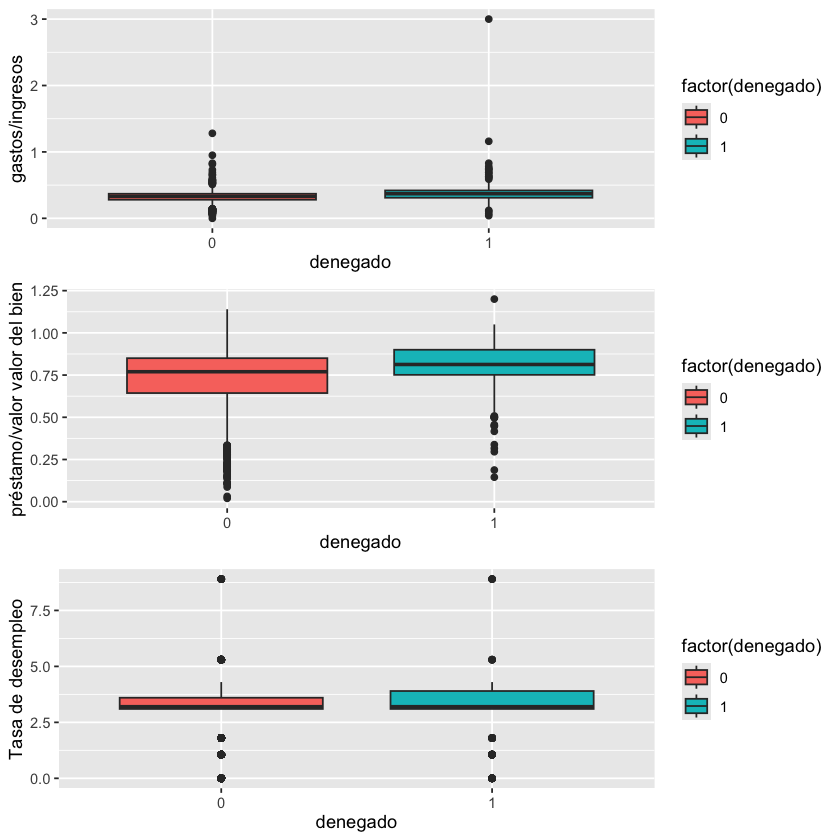

In [13]:
# Se vuelven a ver otra vez los boxplots
bp1 <- ggplot(data = datos2, aes(y = gasto), colour = factor(denegado)) +
  geom_boxplot(aes(x = denegado, fill = factor(denegado))) +
  xlab("denegado") + ylab("gastos/ingresos")

bp2 <-ggplot(data = datos2, aes(y = rat), colour = factor(denegado)) +
  geom_boxplot(aes(x = denegado, fill = factor(denegado))) +
  xlab("denegado") + ylab("préstamo/valor valor del bien") 

bp3 <-ggplot(data = datos2, aes(y = rat.desem), colour = factor(denegado)) +
  geom_boxplot(aes(x = denegado, fill = factor(denegado))) +
  xlab("denegado") + ylab("Tasa de desempleo")

grid.arrange(bp1, bp2, bp3) 

In [14]:
which(datos2$gasto > 2)

[1] 1084

* Se ve un atípico para gastos.. lo dejamos y veremos en el modelo si influye

In [15]:
# Se hace un análisis básico de cada VARIABLE CATEGORICA respecto a "denegado"
# ver si no hay casillas con pocos datos, ya que puede afectar el modelo
# Puede dar alguna idea de como se disribuye la variable objetivo en las categorias de las variables categóricas
table(datos$denegado, datos$malhist) 
table(datos$denegado, datos$auton)
table(datos$denegado, datos$soltero)
table(datos$denegado, datos$malhist3) #en denegado=1 hay pocos con buen historial

prop.table(table(datos$denegado, datos$malhist3)) # se ven las proporciones del total

## OBS!! hay dos variables que parecen medir lo mismo...
table(datos$malhist3, datos$malhist) 
#tomar en cuenta para no incluirlas en el mismo modelo!

   
      no  yes
  0 1996   99
  1  209   76

   
      no  yes
  0 1864  231
  1  239   46

   
      no  yes
  0 1300  795
  1  144  141

   
       1    2    3
  0  274 1722   99
  1   35  174   76

   
             1          2          3
  0 0.11512605 0.72352941 0.04159664
  1 0.01470588 0.07310924 0.03193277

   
      no  yes
  1  309    0
  2 1896    0
  3    0  175

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwid

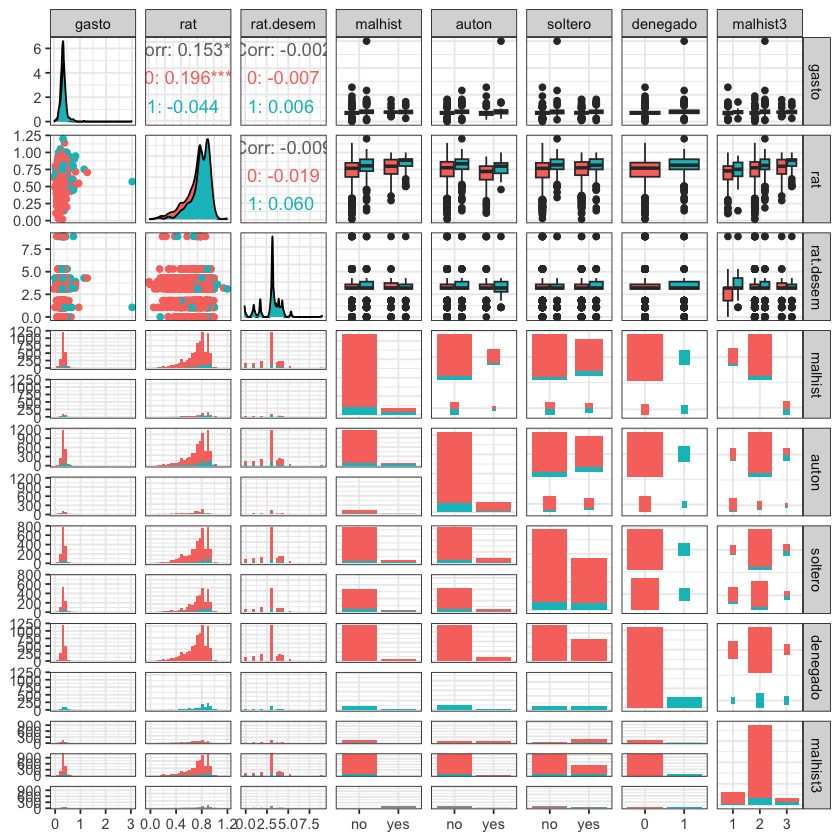

In [16]:
# Se visualiza todo junto
ggpairs(datos2,mapping = aes(colour= denegado)) + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
    theme_bw()

## Conjunto de Entrenamiento y Testing

In [17]:
# Se ajustan modelos en conj de entrenamiento y se lo evalua en conj de testing
set.seed(123)
#indices <- sample(1:nrow(datos), nrow(datos) * 0.70, replace=FALSE)
indices <- createDataPartition(datos2$denegado, p = 0.7, list = FALSE)
dataTrain <- datos2[indices, ] # 70 
dataTest <- datos2[-indices, ] # 30

## Modelos logísticos

In [18]:
# Se decide por ahora no usar "malhist3", modelo casi completo
mod1 <- glm(denegado ~ .-malhist3, data = dataTrain, family = binomial)
summary(mod1)


Call:
glm(formula = denegado ~ . - malhist3, family = binomial, data = dataTrain)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -6.17030    0.61620 -10.013  < 2e-16 ***
gasto        4.60468    0.87665   5.253 1.50e-07 ***
rat          2.81767    0.65356   4.311 1.62e-05 ***
rat.desem   -0.05838    0.06537  -0.893 0.371816    
malhistyes   1.76736    0.21347   8.279  < 2e-16 ***
autonyes     0.42930    0.24848   1.728 0.084043 .  
solteroyes   0.59611    0.16525   3.607 0.000309 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1182.4  on 1648  degrees of freedom
Residual deviance: 1023.2  on 1642  degrees of freedom
AIC: 1037.2

Number of Fisher Scoring iterations: 5


* aparece posfijo "yes" porque crea una variable dummy dicotómica 

In [19]:
# modelo simple, solo con rat
mod2 <- glm(denegado ~ rat, data = dataTrain, family = binomial)
summary(mod2)


Call:
glm(formula = denegado ~ rat, family = binomial, data = dataTrain)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.6044     0.4868  -9.459  < 2e-16 ***
rat           3.3639     0.6071   5.541 3.01e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1182.4  on 1648  degrees of freedom
Residual deviance: 1144.8  on 1647  degrees of freedom
AIC: 1148.8

Number of Fisher Scoring iterations: 5


In [20]:
# modelo con significativas en el modelo completo
mod3 <- glm(denegado ~ gasto + rat + malhist + soltero, data = dataTrain, family = binomial)
summary(mod3)


Call:
glm(formula = denegado ~ gasto + rat + malhist + soltero, family = binomial, 
    data = dataTrain)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -6.1623     0.5832 -10.567  < 2e-16 ***
gasto         4.5827     0.8752   5.236 1.64e-07 ***
rat           2.6599     0.6390   4.163 3.15e-05 ***
malhistyes    1.7722     0.2135   8.299  < 2e-16 ***
solteroyes    0.5942     0.1651   3.600 0.000319 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1182.4  on 1648  degrees of freedom
Residual deviance: 1026.6  on 1644  degrees of freedom
AIC: 1036.6

Number of Fisher Scoring iterations: 5


In [21]:
# modelo con seleccion automática
mod4 <- step(mod1, direction = "backward", trace = 1)
summary(mod4)

Start:  AIC=1037.2
denegado ~ (gasto + rat + rat.desem + malhist + auton + soltero + 
    malhist3) - malhist3

            Df Deviance    AIC
- rat.desem  1   1024.0 1036.0
<none>           1023.2 1037.2
- auton      1   1026.0 1038.0
- soltero    1   1036.2 1048.2
- rat        1   1044.7 1056.7
- gasto      1   1058.2 1070.2
- malhist    1   1085.2 1097.2

Step:  AIC=1035.99
denegado ~ gasto + rat + malhist + auton + soltero

          Df Deviance    AIC
<none>         1024.0 1036.0
- auton    1   1026.6 1036.6
- soltero  1   1036.9 1046.9
- rat      1   1045.3 1055.3
- gasto    1   1058.7 1068.7
- malhist  1   1085.7 1095.7



Call:
glm(formula = denegado ~ gasto + rat + malhist + auton + soltero, 
    family = binomial, data = dataTrain)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -6.3097     0.5962 -10.583  < 2e-16 ***
gasto         4.5586     0.8763   5.202 1.97e-07 ***
rat           2.7982     0.6516   4.294 1.75e-05 ***
malhistyes    1.7641     0.2136   8.258  < 2e-16 ***
autonyes      0.4159     0.2485   1.673 0.094237 .  
solteroyes    0.5942     0.1652   3.596 0.000323 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1182.4  on 1648  degrees of freedom
Residual deviance: 1024.0  on 1643  degrees of freedom
AIC: 1036

Number of Fisher Scoring iterations: 5


### Comparación de modelo según AIC

In [24]:
# Se comparan los modelos segun AIC (comparación de modelos de modo global)
AIC(mod1, mod2, mod3, mod4)

,df,AIC
,<dbl>,<dbl>
mod1,7,1037.199
mod2,2,1148.803
mod3,5,1036.631
mod4,6,1035.990


* Menor es mejor... me quedo con mod4

### Comparación de modelos con desvianzas según ANOVA

In [23]:
# Se comparan los modelos con devianzas
anova(mod1, mod2, mod3, mod4)

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1642,1023.199,NA,NA,NA
2,1647,1144.803,-5,-121.604068,1.435233e-24
3,1644,1026.631,3,118.172279,1.910042e-25
4,1643,1023.990,1,2.640474,1.041725e-01


* ¿cual gana? mod4

### Análisis de modelos

* Para los modelos que elegimos (2 o 3), ver:
* Se hace con el mod3, habria que hacerlo con cada uno...

#### a) ¿Es significativo el modelo?

In [25]:
mod_null <- glm(denegado ~ 1, data = dataTrain, family = binomial)
anova(mod_null, mod3)

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1648,1182.428,NA,NA,NA
2,1644,1026.631,4,155.7974,1.164357e-32


* pvalor muy chico, entonces el modelo es significativo. Es decir, vale la pena modelar con estas variables

#### b) ¿Son todas las variables significativas para el modelo? ver con Wald y con devianzas

In [26]:
# con Wald elijo una variable, ejemplo: variable gasto: pvalor < 2.2e-16, entonces
# es significativo agregar la variable gasto al modelo estando las otras presentes
# significatividad con desvianzas:
mod_sin_gasto <- glm(denegado ~ rat + malhist + soltero, data = dataTrain, family = binomial)
anova(mod3, mod_sin_gasto)

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1644,1026.631,NA,NA,NA
2,1645,1062.008,-1,-35.37752,2.716038e-09


* pvalor muy chico, entonces es significativa la variable gasto

#### c) Considere un test de bondad de ajuste: ¿qué conclusión se obtiene?

In [34]:
# Test H-L 
# H0: el modelo ajusta a los datos
# H1: el modelo no ajusta a los datos
hoslem.test(mod1$y, fitted(mod1))
hoslem.test(mod2$y, fitted(mod2))
hoslem.test(mod3$y, fitted(mod3))
hoslem.test(mod4$y, fitted(mod4))


	Hosmer and Lemeshow goodness of fit (GOF) test

data:  mod1$y, fitted(mod1)
X-squared = 13.585, df = 8, p-value = 0.09325



	Hosmer and Lemeshow goodness of fit (GOF) test

data:  mod2$y, fitted(mod2)
X-squared = 15.294, df = 8, p-value = 0.05368



	Hosmer and Lemeshow goodness of fit (GOF) test

data:  mod3$y, fitted(mod3)
X-squared = 26.918, df = 8, p-value = 0.0007303



	Hosmer and Lemeshow goodness of fit (GOF) test

data:  mod4$y, fitted(mod4)
X-squared = 17.408, df = 8, p-value = 0.02613


* El test de bondad de ajusta mira como H0 (hipótesis nula) el modelo ajustado. Si el modelo es adecuado para ajustar esos datos. Uno quiere no rechazar H0
* Para ir por H0 el pvalor tiene que dar grande
* Se ve en los 4 modelos que los pvalores son chicos (menos de 0.5). Estaria como para rechazar H0
* Estas pruebas no son muy concluyentes, ya que depende mucho de la cantidad de grupos que considere (distribución de los casos)

#### d) Hay puntos influyentes (ver Cook y leverages)

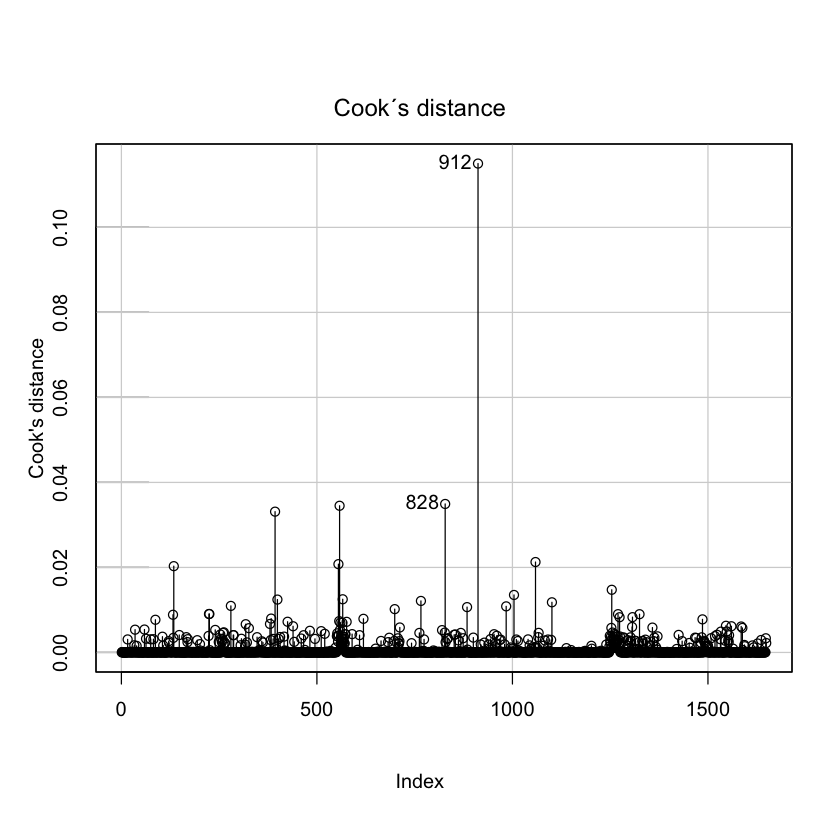

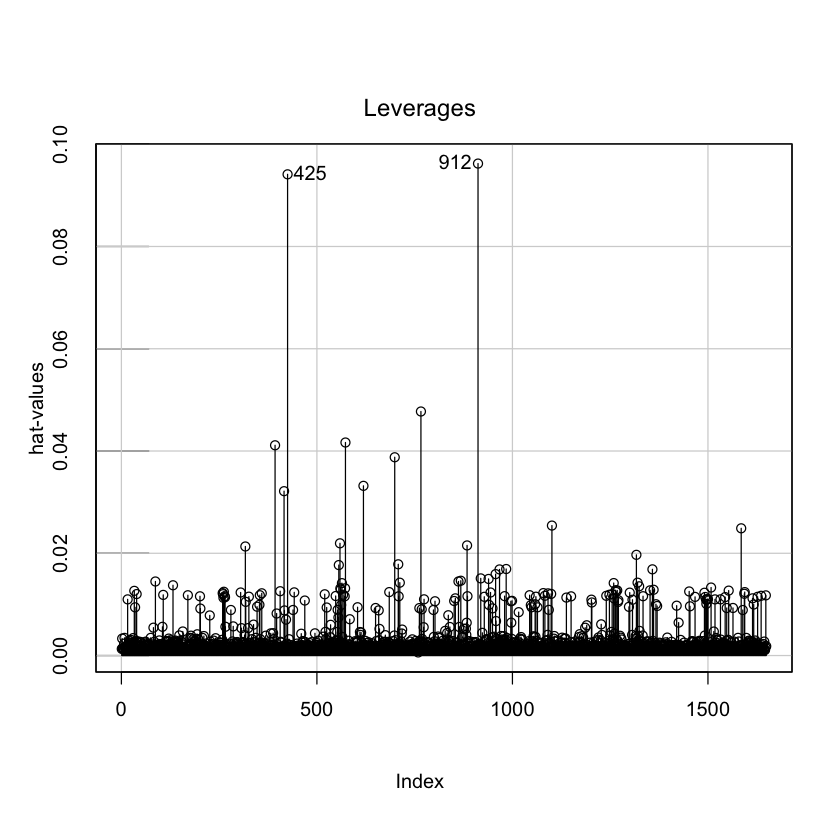

In [35]:
influenceIndexPlot(mod3, vars = "Cook", id = T, main = "Cook´s distance") 
influenceIndexPlot(mod3, vars = "hat", id = T, main = "Leverages") 

* Puntos influyentes: influyen en el modelo, ya sea, en la predicción o en modificar el modelo
* Punto 912, tiene una distancia bastante mas alejada que el resto de los puntos. En un trabajo real, se saca ese punto y se vuelve a analizar. También se pregunta al dueño de los datos

#### e) Indique valores de pseudos R2

In [70]:
PseudoR2(mod3, c("CoxSnell", "Nagel"))
PseudoR2(mod4, c("CoxSnell", "Nagel"))

CoxSnell Nagelkerke 
0.09015402 0.17614625

CoxSnell Nagelkerke 
0.09160976 0.17899051

* Se observa que no son muy distintos
* El mod4 esta un poco mejor al mod3, se elije el mod4

#### f) Analizar Multicolinealidad

In [71]:
vif(mod1) 

gasto       rat rat.desem   malhist     auton   soltero 
 1.011125  1.032293  1.010010  1.010963  1.024754  1.004969

* Se mira sobre el mod1 que estan todas las variables regresoras posibles
* Todos tienen valores bajos, no hay multicolinealidad

## Regresión logística para clasificar

* Para predecir la respuesta "y" (es decir, la probabilidad de que "y" sea 1)
* Para este ejemplo: la probabilidad de que se denegue la hipoteca
* Se trabaja con un modelo (mod3) para evaluar la clasificación en el conjunto de testeo
* Se eligen algunos modelos: Se deberia de hacer también para el mod1 y mod4

## Matriz de confusión o Tabla de clasificación

In [ ]:
# Se genera la prediccion en los datos de test:
# esto calcula probabilidades predichas de "y = 1" en test
proba <- predict.glm(mod3, newdata = dataTest, type = "response")

In [72]:
# LO SIGUIENTE DEPENDE DEL PUNTO DE CORTE!!!!
# Se genera la clase predicha según un punto de corte que se fija (arbitrario):
predi.y <- ifelse(proba >= 0.5, 1, 0)
matriz_confusion <- table(predi.y, dataTest$denegado, dnn = c("predicho", "observado"))
# Tener cuidado con el orden! predicho-observado es como lo toma confusionMatrix
matriz_confusion

        observado
predicho   0   1
       0 618  75
       1   6   6

In [73]:
summary(dataTest) # controlar que la matriz esté en el orden correcto

     gasto             rat           rat.desem     malhist   auton    
 Min.   :0.0400   Min.   :0.0200   Min.   :0.000   no :656   no :620  
 1st Qu.:0.2800   1st Qu.:0.6438   1st Qu.:3.100   yes: 49   yes: 85  
 Median :0.3359   Median :0.7783   Median :3.200                      
 Mean   :0.3271   Mean   :0.7320   Mean   :3.012                      
 3rd Qu.:0.3714   3rd Qu.:0.8678   3rd Qu.:3.600                      
 Max.   :0.9500   Max.   :1.2000   Max.   :8.900                      
 soltero   denegado malhist3
 no :437   0:624    1: 95   
 yes:268   1: 81    2:561   
                    3: 49   
                            
                            
                            

### Indicadores "a mano" en función a la Tabla de Confusión

In [74]:
precision <- precision(matriz_confusion, relevant = "1")        # 6/(6+6)
sensitividad <- recall(matriz_confusion, relevant = "1")        # 6/(6+75)
F1 <- 2 * precision * sensitividad / (precision + sensitividad) # 
especificidad <- recall(matriz_confusion, relevant = "0")       # 
data.frame(precision, sensitividad, especificidad, F1)

precision,sensitividad,especificidad,F1
<dbl>,<dbl>,<dbl>,<dbl>
0.5,0.07407407,0.9903846,0.1290323


* Precision y sensitividad son muy bajas

### Indicadores (cálculo directo) en función de la Tabla de Confusión

In [75]:
matriz <- confusionMatrix(matriz_confusion, positive = "1")
matriz

Confusion Matrix and Statistics

        observado
predicho   0   1
       0 618  75
       1   6   6
                                          
               Accuracy : 0.8851          
                 95% CI : (0.8592, 0.9077)
    No Information Rate : 0.8851          
    P-Value [Acc > NIR] : 0.5296          
                                          
                  Kappa : 0.1024          
                                          
 Mcnemar's Test P-Value : 4.171e-14       
                                          
            Sensitivity : 0.074074        
            Specificity : 0.990385        
         Pos Pred Value : 0.500000        
         Neg Pred Value : 0.891775        
             Prevalence : 0.114894        
         Detection Rate : 0.008511        
   Detection Prevalence : 0.017021        
      Balanced Accuracy : 0.532229        
                                          
       'Positive' Class : 1               
                                      

* Accuracy = cant. decisiones correctas / cant. total de casos

In [76]:
names(matriz)
matriz$byClass[[1]] # para extraer el valor de sensitividad
matriz$byClass[[2]] # para extraer el valor de especificidad
matriz$byClass[[3]] # Pos Pred Value es la precision
## se ve que esta clasificación captura bien los negativos pero muy mal los positivos!!
# hay que mejorar el punto de corte (umbral de clasificación)

[1] "positive" "table"    "overall"  "byClass"  "mode"     "dots"

[1] 0.07407407

[1] 0.9903846

[1] 0.5

### Gráfico para la Tabla de Confusión

        observado
predicho   0   1
       0 618  75
       1   6   6

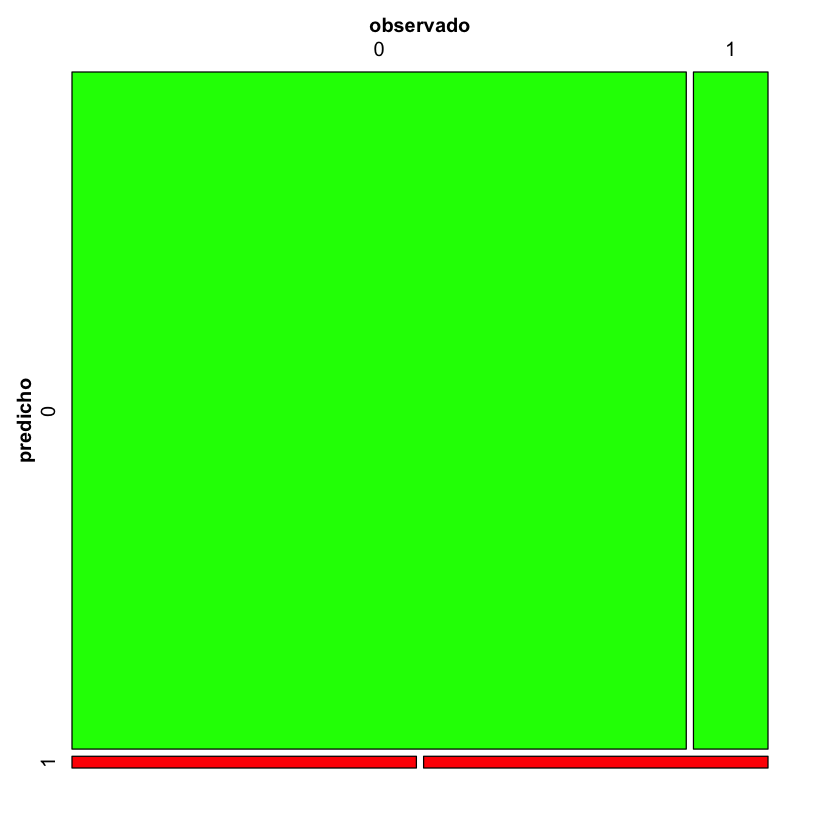

In [77]:
mosaic(matriz_confusion, shade = T, colorize = T, gp = gpar(fill = matrix(c("green", "red", "green", "red"), 2, 2)))
matriz_confusion

## Curva ROC y AUC

* Dos formas de evaluar modelos de clasificación:
    * Tabla de Confusión y métricas que salen de allí
    * Capacidad predictiva del modelo, arma curva ROC y calcula la curva perfecta.
* Buscar modelos que tengan alta capacidad predictiva (cercana a 1)

In [ ]:
proba3 <- predict.glm(mod3, newdata = dataTest, type = "response")
prediccion3 <- prediction(proba3, dataTest$denegado)

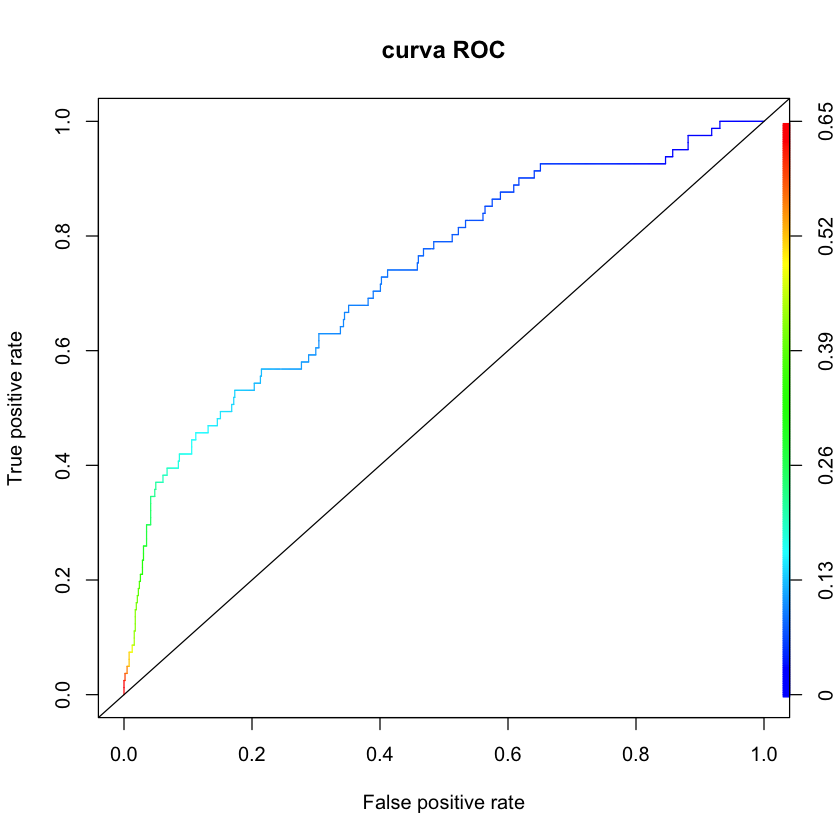

In [78]:
# Se genera objeto con la prediccion
roc_modelo3 <- performance(prediccion3, measure = "tpr", x.measure = "fpr")
plot(roc_modelo3, main = "curva ROC", colorize = T)
abline(a = 0, b = 1)

In [82]:
# Se calcula el área bajo la curva ROC (AUC)
AUC3 <- performance(prediccion3, "auc")@y.values
AUC3 

## Si bien aqui lo hicimos con un solo modelo, lo habitual es con devianzas y AIC elegir un par de modelos y
## sobre estos calcular las metricas en test para elegir el modelo ganador

[[1]]
[1] 0.7368629

* El área bajo la curva ROC mide la **capacidad predictiva** del modelo
* En este ejemplo, se visualiza que el modelo tiene una buena capacidad predictiva

[[1]]
[1] 0.7452714

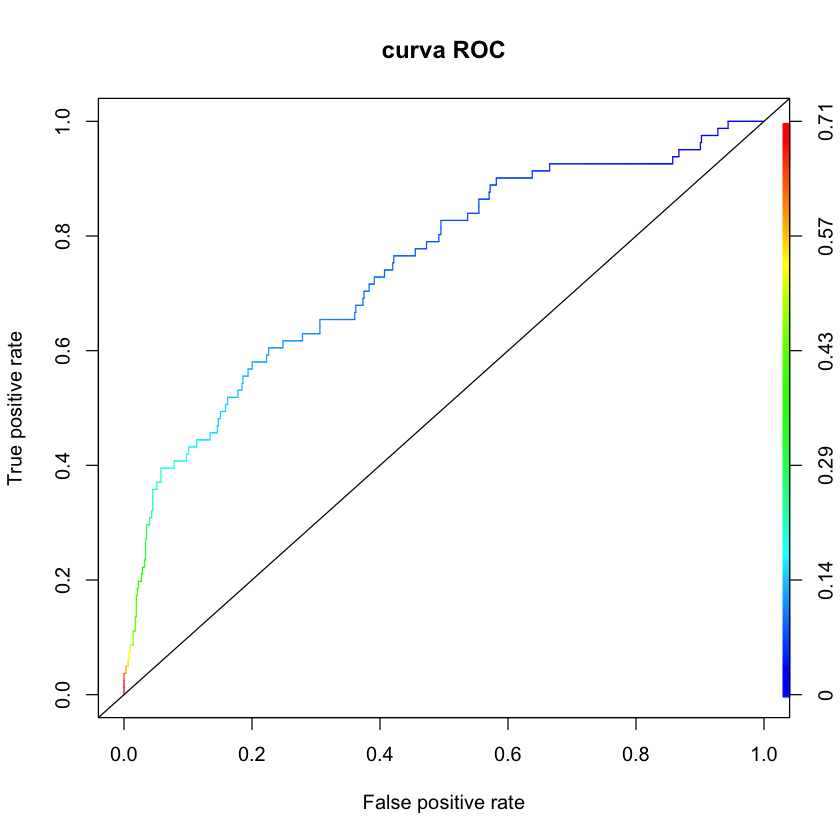

In [83]:
# Se hace lo mismo con el modelo 4 (mod4)
proba4 <- predict.glm(mod4, newdata = dataTest, type = "response")
prediccion4 <- prediction(proba4, dataTest$denegado)
roc_modelo4 <- performance(prediccion4, measure = "tpr", x.measure = "fpr")
plot(roc_modelo4, main = "curva ROC", colorize = T)
abline(a = 0, b = 1)
AUC4 <- performance(prediccion4, "auc")@y.values
AUC4 

* En la evaluación de test, se tiene argumentos para decir que se elige mod4, ya que AUC4 = 0.74 es mayor a AUC3 = 0.73

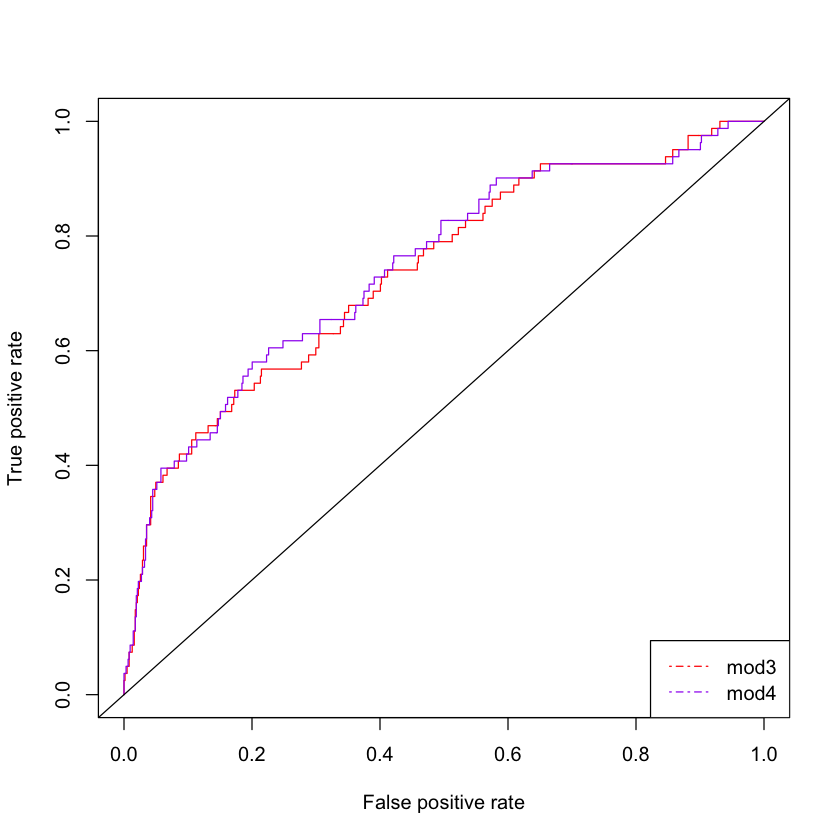

In [87]:
# Se grafican ambas curvas
plot(roc_modelo3, col = "red")
plot(roc_modelo4, col = "purple", add = TRUE)
legend("bottomright", legend = c("mod3", "mod4"), col = c("red", "purple"), lty = 4)
abline(a = 0, b = 1)

## Elección del modelo/s

* Según AUC, Accuracy, Sensibilidad, Especificidad, Precisión, F1

## EXTRA 1: calcular punto de corte

In [98]:
# Se busca un punto de corte adecuado para la matriz de confusion:
# rep: replica 1 en una determinada longitud (crea vector)
pc <- seq(from = 0.1, to = 0.6, by = 0.1)
accu <- rep(1, length(pc))
sens <- rep(1, length(pc))
spec <- rep(1, length(pc))
preci <- rep(1,length(pc))
F1 <- rep(1, length(pc))

proba <- predict.glm(mod3, newdata = dataTest, type = "response")

for(i in 1:length(pc)) {
    pred_y <- ifelse(proba > i/10, 1, 0)
    confusion <- table(pred_y, dataTest$denegado)
    VP <- confusion[2,2] #lo defino así para que se vea desde la tabla
    VN <- confusion[1,1]
    FP <- confusion[2,1]
    FN <- confusion[1,2]
    accu[i] <- (VP+VN)/(VP+VN+FP+FN)
    sens[i] <- VP/(VP+FN)
    spec[i] <- VN/(VN+FP)
    preci[i] <- VP/(VP+FP)
    F1[i] <- 2*preci[i]*sens[i]/(sens[i]+preci[i])
}
df_mod.log = data.frame(
  Umbral = pc,
  Accuracy= accu,
  Precision = preci,
  Sensibilidad = sens,
  Especificidad = spec,
  F1 = F1
)
df_mod.log 

Umbral,Accuracy,Precision,Sensibilidad,Especificidad,F1
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.1,0.6340426,0.1916376,0.67901235,0.6282051,0.29891304
0.2,0.8723404,0.4366197,0.38271605,0.9358974,0.40789474
0.3,0.8865248,0.5128205,0.24691358,0.9695513,0.33333333
0.4,0.8865248,0.5185185,0.17283951,0.9791667,0.25925926
0.5,0.8851064,0.5000000,0.07407407,0.9903846,0.12903226
0.6,0.8879433,1.0000000,0.02469136,1.0000000,0.04819277


In [ ]:
# gráfico sensitividad y especificidad
ggplot(df_mod.log, aes(x = Umbral) )+
  geom_line(aes(y = Sensibilidad, color = "Sensibilidad")) +
  geom_line(aes(y = Especificidad, color = "Especificidad")) +
  labs(y = "Valor", color = "") +
  theme_minimal()

* ¿Cómo se elige el punto de corte? Es subjetivo
* Se observa que se podria elegir punto de corte en el rango 0.1 - 0.5 para maximizar sensibilidad, precisión, ...

## EXTRA 2: modelo con una categórica de 3 categorías

In [102]:
mod5 <- glm(denegado ~ gasto + malhist, data = dataTrain, family = binomial)
summary(mod5)


Call:
glm(formula = denegado ~ gasto + malhist, family = binomial, 
    data = dataTrain)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.0482     0.3258 -12.427  < 2e-16 ***
gasto         5.1236     0.8883   5.768 8.01e-09 ***
malhistyes    1.8501     0.2086   8.870  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1182.4  on 1648  degrees of freedom
Residual deviance: 1060.4  on 1646  degrees of freedom
AIC: 1066.4

Number of Fisher Scoring iterations: 5


$$logit = -4.04 + 5.12 gasto + 1.85 malhistyes$$

* malhistyes : Zyes
* El modelo para los que tienen buen historial: cuando Zyes = 1 si malhist = yes y Zyes = 0 si malhist = no
$$logit = -4.04 + 5.12 gasto$$
* EL modelo para los que tienen mal historial
$$logit = -4.04 + 5.12 gasto + 1.85$$

* Interpretación

$$e^{1.85} = 6.36 = \dfrac{ODD(Zyes=1)}{ODD(Zyes=0)}$$

* ODD(Zyes=1) = 6.36 * ODD(Zyes=0)
* ODD(Zyes=1) es la chance de que deneguen la hipoteca si tiene mal historial (Zyes=1)
* ODD(Zyes=0) es la chance de que deneguen la hipoteca si NO tiene mal historial (Zyes=0) 

In [107]:
# malhist3 tiene 3 categorias
mod5b <- glm(denegado ~ gasto + malhist3, data = dataTrain, family = binomial)
summary(mod5b)


Call:
glm(formula = denegado ~ gasto + malhist3, family = binomial, 
    data = dataTrain)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -3.8591     0.3909  -9.873  < 2e-16 ***
gasto         5.1030     0.8877   5.748 9.02e-09 ***
malhist32    -0.2131     0.2485  -0.857    0.391    
malhist33     1.6684     0.2955   5.645 1.65e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1182.4  on 1648  degrees of freedom
Residual deviance: 1059.7  on 1645  degrees of freedom
AIC: 1067.7

Number of Fisher Scoring iterations: 5


* La variable malhist3 es una variable categórica que tiene 3 categorias: 1, 2, 3
* malhist32: Z2
* malhist33. Z3

| categoria | Z2 | Z3 |
| --        | -- | -- |
| 1         | 0  | 0  |
| 2         | 1  | 0  |
| 3         | 0  | 1  |

$$e^{-0.21} = 0.81 = \dfrac{ODD(Z2=1)}{ODD(Z2=0)}$$

* ODD(Z2=1) = 0.81 * ODD(Z2=0)
* ODD(Z2=1) es la chance de que deneguen la hipoteca si historial = 2
* ODD(Z2=0) es la chance de que deneguen la hipoteca si historial = 1
* OJO Z2 no es SIGNIFICATIVA!!!! No hay diferencia significativa entre historial = 1 e historial = 2. Hay que colapsarla (agruparlas)